In [124]:
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from enum import Enum
from enum import auto
from itertools import combinations
from pprint import pprint
from typing import override
from unicodedata import normalize

import matplotlib.pyplot as plt
import nltk
import numpy as np
from datasets import load_dataset
from nltk.tokenize import sent_tokenize
from sentence_transformers import CrossEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm


In [101]:
nltk.download("punkt", download_dir='.nltk/')

[nltk_data] Downloading package punkt to .nltk/...
[nltk_data]   Package punkt is already up-to-date!


True

In [102]:
print('Loading datasets...')
dataset_snli = load_dataset('stanfordnlp/snli', split='test')
dataset_mnli = load_dataset('nyu-mll/multi_nli', split='validation_matched')
dataset_anli = load_dataset('facebook/anli', split='test_r3')
print('Loading datasets done.')

Loading datasets...
Loading datasets done.


In [103]:
class Label(Enum):
    ENTAILMENT = auto()
    NOT_ENTAILMENT = auto()
    NOT_AVAILABLE = auto()


@dataclass
class Example:
    premise: str
    hypothesis: str
    label: Label


class ExampleSNLI(Example):
    def __init__(self, example: dict):
        label = self._to_binary_class(example['label'])
        super().__init__(example['premise'], example['hypothesis'], label)
    
    def _to_binary_class(self, label: int) -> Label:
        return Label.ENTAILMENT if label == 0 else Label.NOT_ENTAILMENT


class ExampleMNLI(Example):
    def __init__(self, example: dict):
        label = self._to_binary_class(example['label'])
        super().__init__(example['premise'], example['hypothesis'], label)
    
    def _to_binary_class(self, label: int) -> Label:
        return Label.ENTAILMENT if label == 0 else Label.NOT_ENTAILMENT


class ExampleANLI(Example):
    def __init__(self, example: dict):
        label = self._to_binary_class(example['label'])
        super().__init__(example['premise'], example['hypothesis'], label)
    
    def _to_binary_class(self, label: int) -> Label:
        return Label.ENTAILMENT if label == 0 else Label.NOT_ENTAILMENT

In [104]:
examples_snli = [ExampleSNLI(example) for example in dataset_snli]
examples_mnli = [ExampleMNLI(example) for example in dataset_mnli]
examples_anli = [ExampleANLI(example) for example in dataset_anli]

In [125]:
class Model(ABC):
    @abstractmethod
    def predict(self, example: Example) -> int:
        pass
    
    @abstractmethod
    def predict_batch(self, examples: list[Example]) -> list[int]:
        pass

    @abstractmethod
    def tokenize(self, premise: str, hypothesis: str) -> list[int]:
        pass

    @abstractmethod
    def get_max_token_length(self) -> int:
        pass


class SBERT(Model):
    def __init__(self, pretrained_model_name: str):
        self.model = CrossEncoder(pretrained_model_name)
        self.tokenizer = self.model.tokenizer
        self.max_token_length = self.model.tokenizer.model_max_length
        self.ENTAILMENT = 1 # see https://huggingface.co/cross-encoder/nli-deberta-v3-small
    
    @override
    def predict(self, example: Example) -> Label:
        score = self.model.predict([(example.premise, example.hypothesis)])[0]
        return Label.ENTAILMENT if np.argmax(score) == self.ENTAILMENT else Label.NOT_ENTAILMENT
    
    @override
    def predict_batch(self, examples: list[Example]) -> list[Label]:
        scores = self.model.predict([(example.premise, example.hypothesis) for example in examples])
        return [Label.ENTAILMENT if np.argmax(score) == self.ENTAILMENT else Label.NOT_ENTAILMENT for score in scores]

    @override
    def tokenize(self, premise: str, hypothesis: str) -> list[int]:
        tokens = self.tokenizer.tokenize(premise, hypothesis)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        return token_ids

    @override
    def get_max_token_length(self) -> int:
        return self.max_token_length

In [ ]:
def select_k_sentences(text: str, k: int) -> list[str]:
    sentences = sent_tokenize(normalize('NFKC', text))
    return [' '.join(comb) for comb in combinations(sentences, k)]


def breakdown_sub_examples(model: Model, example: Example, num_of_select_sentences: int = 0) -> list[Example]:
    if num_of_select_sentences <= 0:
        return [Example(example.premise, example.hypothesis, Label.NOT_AVAILABLE)]
    max_token_length = model.get_max_token_length()
    sub_examples = []
    for k in range(1, num_of_select_sentences + 1):
        sub_premises = select_k_sentences(example.premise, k)
        for sub_premise in sub_premises:
            tokens = model.tokenize(sub_premise, example.hypothesis)
            if len(tokens) > max_token_length:  # skip this sub-example if it would exceed the model's token limit
                continue
            sub_examples.append(Example(sub_premise, example.hypothesis, Label.NOT_AVAILABLE))
    return sub_examples

In [ ]:
def metrics(y_true: list[Label], y_pred: list[Label]) -> tuple[float, float, float, float]:
    y_true = [0 if label == Label.ENTAILMENT else 1 for label in y_true]
    y_pred = [0 if label == Label.ENTAILMENT else 1 for label in y_pred]
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    return accuracy, precision, recall, f1


def any_entailment(y_pred: list[Label]) -> Label:
    return Label.ENTAILMENT if any(label == Label.ENTAILMENT for label in y_pred) else Label.NOT_ENTAILMENT


def evaluate_model(model: Model, examples: list[Example], num_of_select_sentences: int = 0, use_batch: bool = True) -> dict:
    y_true = [example.label for example in examples]
    y_pred = []

    if use_batch:
        # flatten all sub-examples, and predict them at once
        # this is much faster than predicting them one by one
        all_sub_examples = []
        num_of_sub_examples = []
        for example in examples:
            sub_examples = breakdown_sub_examples(model, example, num_of_select_sentences)
            all_sub_examples.extend(sub_examples)
            num_of_sub_examples.append(len(sub_examples))
        all_pred_labels = model.predict_batch(all_sub_examples)
        offset = 0
        for num_of_sub_example in num_of_sub_examples:
            sub_pred_labels = all_pred_labels[offset : offset + num_of_sub_example]
            offset += num_of_sub_example
            y_pred.append(any_entailment(sub_pred_labels))
    else:
        # predict each sub-example one by one
        for example in tqdm(examples, position=0):
            sub_examples = breakdown_sub_examples(model, example, num_of_select_sentences)
            pred_labels = []
            for sub_example in tqdm(sub_examples, position=1, leave=False):
                pred_label = model.predict(sub_example)
                pred_labels.append(pred_label)
            y_pred.append(any_entailment(pred_labels))

    accuracy, precision, recall, f1 = metrics(y_true, y_pred)
    return { 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1 }

In [127]:
model = SBERT('cross-encoder/nli-deberta-v3-small')

# print('Evaluating model on SNLI...')
# metrics_snli = evaluate_model_metrics(model, examples_snli)
# pprint(metrics_snli)

# print('Evaluating model on MNLI...')
# metrics_mnli = evaluate_model_metrics(model, examples_mnli)
# pprint(metrics_mnli)

print('Evaluating model on ANLI...')
metrics_anli = evaluate_model(model, examples_anli)
pprint(metrics_anli)

Evaluating model on ANLI...
{'accuracy': 0.6066666666666667,
 'f1': 0.7386489479512736,
 'precision': 0.6617063492063492,
 'recall': 0.8358395989974937}


In [111]:
scores: dict[int, object] = {}
for num_of_select_sentences in range(1, 10):
    metrics_anli = evaluate_model(model, examples_anli, num_of_select_sentences=num_of_select_sentences)
    scores[num_of_select_sentences] = metrics_anli

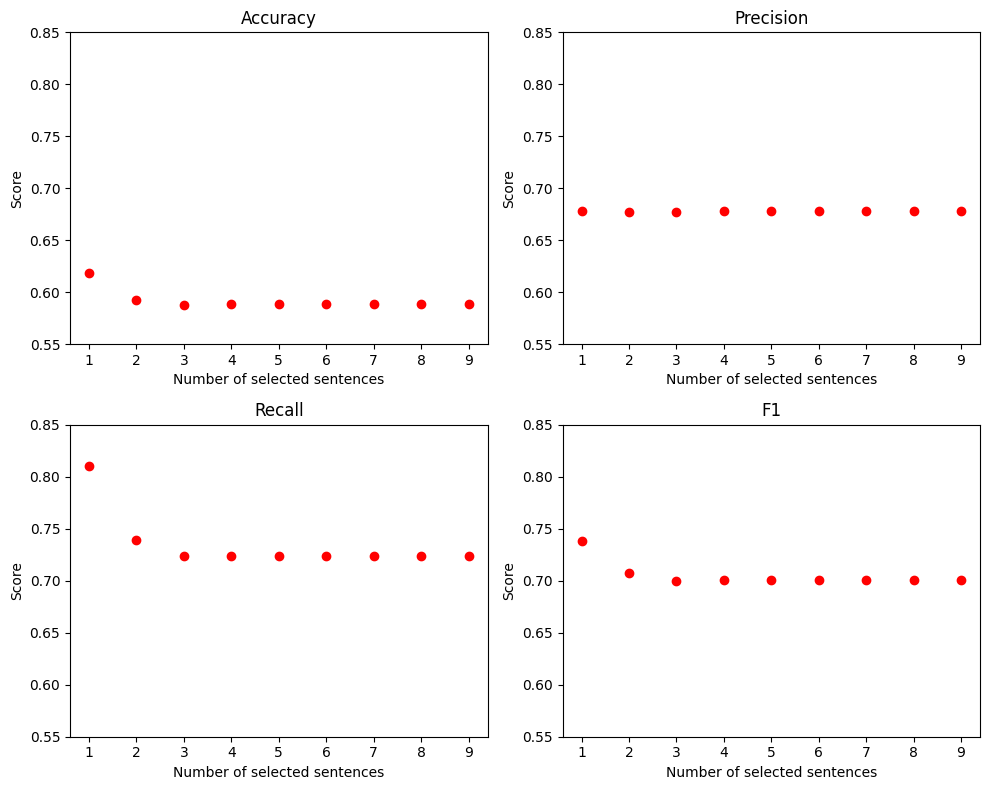

In [121]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for num_of_select_sentences, score in scores.items():
    ax[0, 0].plot(num_of_select_sentences, score['accuracy'], 'ro')
    ax[0, 1].plot(num_of_select_sentences, score['precision'], 'ro')
    ax[1, 0].plot(num_of_select_sentences, score['recall'], 'ro')
    ax[1, 1].plot(num_of_select_sentences, score['f1'], 'ro')
ax[0, 0].set_title('Accuracy')
ax[0, 1].set_title('Precision')
ax[1, 0].set_title('Recall')
ax[1, 1].set_title('F1')
ax[0, 0].set_xlabel('Number of selected sentences')
ax[0, 1].set_xlabel('Number of selected sentences')
ax[1, 0].set_xlabel('Number of selected sentences') 
ax[1, 1].set_xlabel('Number of selected sentences')
ax[0, 0].set_ylabel('Score')
ax[0, 1].set_ylabel('Score')
ax[1, 0].set_ylabel('Score')
ax[1, 1].set_ylabel('Score')
ax[0, 0].set_ylim(0.55, 0.85)
ax[0, 1].set_ylim(0.55, 0.85)
ax[1, 0].set_ylim(0.55, 0.85)
ax[1, 1].set_ylim(0.55, 0.85)
plt.tight_layout()
plt.show()